In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-06 20:46:07.591018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 20:46:07.591059: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'scDart'
modality_names = ['ATAC', 'RNA']
data1 = pd.read_csv('../data/scDART/Endo/counts_atac.csv', index_col=0)
data2 = pd.read_csv('../data/scDART/Endo/counts_rna.csv', index_col=0)
type1 = pd.read_csv('../data/scDART/Endo/anno_atac.txt', header=None).iloc[:, 0].to_numpy()
type2 = pd.read_csv('../data/scDART/Endo/anno_rna.txt', header=None).iloc[:, 0].to_numpy()
f1 = data1.columns
f2 = data2.columns
data1 = data1.to_numpy()
data2 = data2.to_numpy()

# Sampling
data1_col_idx = np.random.choice(range(data1.shape[0]), 301, replace=False)
data2_col_idx = np.random.choice(range(data2.shape[0]), 300, replace=False)
data1, type1 = (x[data1_col_idx] for x in (data1, type1))
data2, type2 = (x[data2_col_idx] for x in (data2, type2))

# Labels
labels = [type1, type2]
features = [f1, f2]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

In [5]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [6]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 150
pca_dim = [64, 64]
dist_method = 'cosine'

# ComManDo

In [7]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (301, 11487)
Dataset 1: (300, 497)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:1.0124 alpha:0.1399
epoch:[1000/2000] err:1.0120 alpha:0.1478
epoch:[1500/2000] err:1.0148 alpha:0.1526
epoch:[2000/2000] err:1.0076 alpha:0.1556
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.326069
epoch:[1000/2000]: loss:1.070588
epoch:[1500/2000]: loss:1.031296
epoch:[2000/2000]: loss:0.974922
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.7442410710009426
Correspondence: 8.764114003000941
Mapping: 46.72087595799894
Total: 56.229231032000826



# Comparison Methods

In [8]:
# MMD-MA
from sklearn.metrics import pairwise_distances
mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)

# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)

2022-09-06 20:47:08.616000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-06 20:47:08.616039: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-06 20:47:08.616055: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IR8CEDI): /proc/driver/nvidia/version does not exist
2022-09-06 20:47:08.616252: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


use random seed: 666
Shape of Raw data
Dataset 0: (301, 11487)
Dataset 1: (300, 497)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:2.8069 alpha:0.1958
epoch:[200/2000] err:1.3200 alpha:0.1274
epoch:[300/2000] err:1.0701 alpha:0.1339
epoch:[400/2000] err:1.0203 alpha:0.1375
epoch:[500/2000] err:1.0074 alpha:0.1400
epoch:[600/2000] err:1.0037 alpha:0.1420
epoch:[700/2000] err:1.0032 alpha:0.1437
epoch:[800/2000] err:1.0038 alpha:0.1453
epoch:[900/2000] err:1.0049 alpha:0.1467
epoch:[1000/2000] err:1.0061 alpha:0.1480
epoch:[1100/2000] err:1.0073 alpha:0.1491
epoch:[1200/2000] err:1.0082 alpha:0.1501
epoch:[1300/2000] err:1.0088 alpha:0.1511
epoch:[1400/2000] err:1.0091 alpha:0.1519
epoch:[1500/2000] err:1.0090 alpha:0.1527
epoch:[1600/2000] err:1.0086 alpha:0.1534
epoch:[1700/2000] err:1.0077 alpha:0.1541
epoch:[1800/2000] err:1.0064 alpha:0.1547
epoch:[1900/2000] err:1.0047 alpha:0.1552
epoch:[2000/2000] err:1.

# Visualization

In [9]:
integrated_data = [cm_data, mmd_ma_data, uc_data]
integrated_names = ['JAMIE', 'MMD-MA', 'Unioncom']
colors = ['blue', 'yellow', 'teal']

sns.set(style='whitegrid')
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 18})

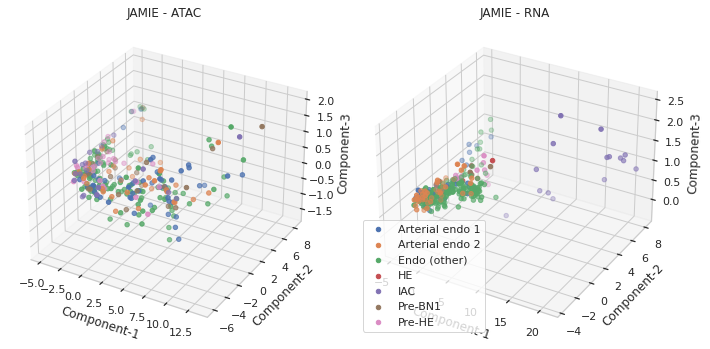

In [10]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

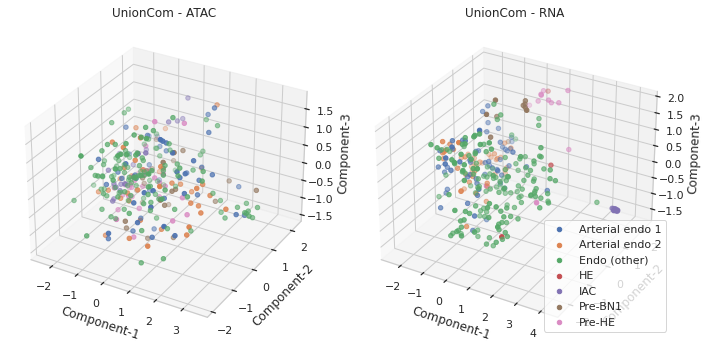

In [11]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(uc_data, labels, ['UnionCom - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-UnionCom.png')

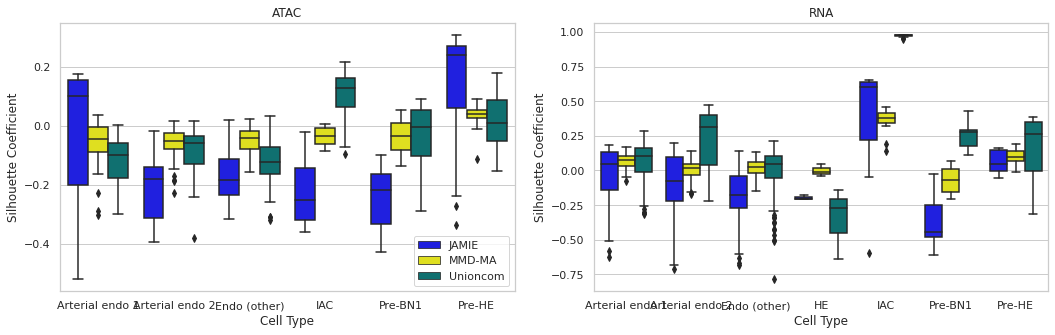

In [12]:
plt.figure(figsize=(15, 5))
plot_silhouette(integrated_data, labels, integrated_names, modality_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

# Explanation

In [13]:
# Integration
kwargs = {
    'output_dim': 1,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
cm_thin = ComManDo(**kwargs)
cm_thin_data = cm_thin.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (301, 11487)
Dataset 1: (300, 497)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:1.0124 alpha:0.1399
epoch:[1000/2000] err:1.0120 alpha:0.1478
epoch:[1500/2000] err:1.0148 alpha:0.1526
epoch:[2000/2000] err:1.0076 alpha:0.1556
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:3.747679
epoch:[1000/2000]: loss:3.506130
epoch:[1500/2000]: loss:3.458938
epoch:[2000/2000]: loss:3.421201
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 1.2027663339995343
Correspondence: 8.082295657999566
Mapping: 163.60203839600035
Total: 172.88710038799945



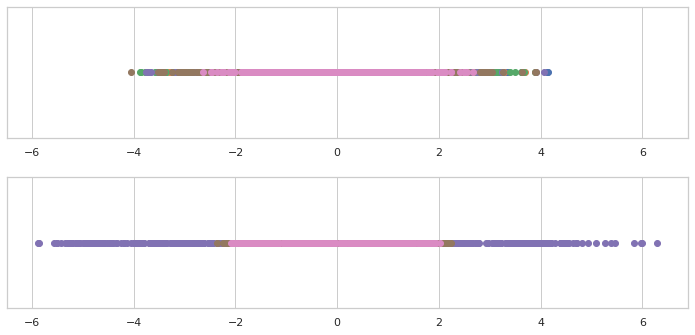

In [14]:
plt.figure(figsize=(10, 5))
axs = plt.gcf().subplots(2, 1)
for i, ax in enumerate(axs):
    for l in np.unique(np.concatenate(labels)):
        ax.scatter(cm_data[i][labels[i] == l], np.zeros_like(cm_data[i][labels[i] == l]), label=l)
    ax.set_yticks([])
min_lim = min(axs[0].get_xlim()[0], axs[1].get_xlim()[0])
max_lim = max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])
for ax in axs:
    ax.set_xlim([min_lim, max_lim])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Line.png');